# Model selection (E)

**method**:

* 10 minutes of recording

* TODO:
    * evaluate training goodness of fit with loss functions plot
    * identify best model with precision and recalls plot

* TODO:
    * use model object to make new predictions (e.g., on evoked dataset)

### Setup

setup cebraspike3 virtual environment.

In [2]:
%load_ext autoreload
%autoreload 2
import os
import torch
import numpy as np
from matplotlib import pyplot as plt

# set project path
proj_path = "/gpfs/bbp.cscs.ch/project/proj85/home/laquitai/spikebias/"
os.chdir(proj_path)

from src.nodes.utils import get_config
from src.nodes import utils 
from src.nodes.models.Flc import dataloader as flc_dataloader
from src.nodes.models.CebraSpike import dataloader as cs_dataloader
from src.nodes.models.Flc.models import FlcModel # FLC model
from src.nodes.models.CebraSpike.models import CebraSpike # FLC model
from src.nodes.models.CebraSpike import plotutils

# npx spont. biophy.
cfg_e, _ = get_config("silico_neuropixels", "stimulus").values()
KS4_e_10m = cfg_e["sorting"]["sorters"]["kilosort4"]["10m"][
    "output"
]  # sorting with KS4
GT_e_10m = cfg_e["sorting"]["simulation"]["ground_truth"]["10m"]["output"] # KS4 sorting
STUDY_e = cfg_e["postprocessing"]["waveform"]["sorted"]["study"]["kilosort4"][
    "10m"
]  # WaveformExtractor
STUDY_e_su = '/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/0_silico/4_spikesorting_stimulus_test_neuropixels_8-1-24__8slc_80f_360r_50t_200ms_1_smallest_fiber_gids/0fcb7709-b1e9-4d84-b056-5801f20d55af/postpro/realism/spike/sorted/study_ks4_10m_single_units'

# PATHS
# pre-computed sorted unit quality
quality_path = "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/analysis/sorting_quality/sorting_quality.csv"

# model save path
flc_model_path = "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/analysis/sorting_quality/models/evoked/flc/crossval_data"
cs_model_path = "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/analysis/sorting_quality/models/evoked/cebra/crossval_data"

# axes
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 6  # 5-7 with Nature neuroscience as reference
plt.rcParams["lines.linewidth"] = 0.5 # typically between 0.5 and 1
plt.rcParams["axes.linewidth"] = 0.5 #1
plt.rcParams["axes.spines.top"] = False
plt.rcParams["xtick.major.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["xtick.minor.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["ytick.major.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["ytick.minor.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["xtick.major.size"] = 3.5 * 1.1
plt.rcParams["xtick.minor.size"] = 2 * 1.1
plt.rcParams["ytick.major.size"] = 3.5 * 1.1
plt.rcParams["ytick.minor.size"] = 2 * 1.1
# legend
legend_cfg = {"frameon": False, "handletextpad": 0.5}
tight_layout_cfg = {"pad": 0.001}
LG_FRAMEON = False              # no legend frame

## Specs

In [ ]:
# check for GPU
use_cuda = torch.cuda.is_available()
if use_cuda:
    print("__CUDNN VERSION:", torch.backends.cudnn.version())
    print("__Number CUDA Devices:", torch.cuda.device_count())
    print("__CUDA Device Name:", torch.cuda.get_device_name(0))
    print(
        "__CUDA Device Total Memory [GB]:",
        torch.cuda.get_device_properties(0).total_memory / 1e9,
    )

__CUDNN VERSION: 90100
__Number CUDA Devices: 4
__CUDA Device Name: Tesla V100-SXM2-16GB
__CUDA Device Total Memory [GB]: 16.935419904


## (1m) FLC model 

* dataset:
    * 182 units: they need to have all their metrics (discard those with missing metrics (np.nan) to be included
    * 10 metrics: amplitude_cutoff', 'firing_range', 'firing_rate',
       'isi_violations_ratio', 'presence_ratio', 'rp_contamination',
       'rp_violations', 'sd_ratio', 'snr', 'silhouette, 'mad_ratio'
* evaluation:
    * 75/25 cross-validation scheme with 100 seeds

In [ ]:
# load the dataset formatted for the model
data_flc = flc_dataloader.load_dataset(
    quality_path, "E", "KS4", KS4_e_10m, STUDY_e, STUDY_e_su, GT_e_10m
)

# instantiate the model
flcmodel = FlcModel(data_flc["predictors"])

# train and evaluate with cross-validation
flc_results = flcmodel.evaluate(
    data_flc["dataset"], seeds=np.arange(0, 100, 1), scale_data=False
)
display(flc_results["metric_stats"])

NameError: name 'flc_dataloader' is not defined

## (12m)CebraSpike model

* the model needs at least 40 iterations for convergence (takes 11 minutes for 100 seeds)
* Dataset:
    * units need to have at least 25 spikes during the 10 minutes of recording (0.016 sp/s)
    * units need to have all their metrics (discard those with missing metrics (np.nan))
* Note: you might encounter CUDA memory issue. Restart the kernel.

In [4]:
# set parameters
torch.manual_seed(0)  # ensure reproducibility

# load the dataset formatted for the model
data_cs = cs_dataloader.load_dataset(
    qpath=quality_path,
    sorting_path=KS4_e_10m,
    sortingtrue_path=GT_e_10m,
    study_path=STUDY_e,
    study_singleu_path=STUDY_e_su,
    exp="E",
    sorter="KS4",
    n_site=384,
    num_spikes=25,
    interval_ms=3,
    downsampling=1,
    load_we_if_exists=True,
    load_amp_if_exists=True,
    load_qmetrics_if_exists=False,
)

# instantiate the model
csmodel = CebraSpike(
    cfg={
        "model_architecture": "offset10-model",  # receptive field of size 10
        "distance": "cosine",  # adapted to contrastive learning
        "batch_size": data_cs["dataset"]["data"].shape[1],  # full dataset
        "temperature_mode": "auto",
        "learning_rate": 0.001,
        "max_iterations": 40,
        "conditional": "time_delta",
        "time_offsets": 10,  # 10 timesteps (should be >= size of receptve fields)
        "output_dimension": 3,  # number of dimensions of the embedding
        "device": "cuda_if_available",
        "verbose": True,
    }
)

# train and evaluate with cross-validation
utils.create_if_not_exists(os.path.dirname(cs_model_path))

cs_results = csmodel.evaluate(
    data_cs["dataset"],
    cs_model_path,
    is_train=True,
    seeds=np.arange(0, 100, 1),
    n_neighbors=20,
)
display(cs_results["metric_stats"])

2024-10-03 19:29:36,444 - root - dataloader.py - load_dataset - INFO - Starting loading dataset..
2024-10-03 19:29:36,445 - root - dataloader.py - load_dataset - INFO - Computing sorted unit quality metrics..


/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/envs/cebraspike3/lib/python3.9/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/envs/cebraspike3/lib/python3.9/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/envs/cebraspike3/lib/python3.9/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/envs/cebraspike3/lib/python3.9/site-packages/spikeinterface/qualitymetrics/misc_metrics.py:235: RuntimeWarning: divide by zero encountered in scalar divide
  snrs[unit_id] = np.abs(amplitude) / noise
/gpfs/bbp.cs

  0%|          | 0/408 [00:00<?, ?it/s]

****************** Analysing data completion ***************
quality metrics are: Index(['amplitude_cutoff', 'firing_range', 'firing_rate',
       'isi_violations_ratio', 'presence_ratio', 'rp_contamination',
       'rp_violations', 'sd_ratio', 'snr', 'silhouette', 'mad_ratio'],
      dtype='object')
Data completion: amplitude_cutoff        408
firing_range            408
firing_rate             408
isi_violations_ratio    408
presence_ratio          408
rp_contamination        408
rp_violations           408
sd_ratio                408
snr                     408
silhouette              407
mad_ratio               408
dtype: int64
Dropping units with missing metrics...
nb of units before curation: 408
nb of units after curation: 407
2024-10-03 19:35:23,650 - root - dataloader.py - load_dataset - INFO - Computed quality metrics
Recording sampling frequency: 20000.0
ex. dataset shape (L4): (36, 3000)
ex. label shape (L4): (36,)

unit sample size:

L1:  0 units
L23:  7 units
L4:  36 unit

pos: -1.0291 neg:  8.5715 total:  7.5424 temperature:  0.9651: 100%|██████████| 40/40 [00:08<00:00,  4.65it/s]
pos: -1.0323 neg:  8.5777 total:  7.5454 temperature:  0.9636: 100%|██████████| 40/40 [00:01<00:00, 21.42it/s]
pos: -1.0254 neg:  8.5751 total:  7.5496 temperature:  0.9679: 100%|██████████| 40/40 [00:01<00:00, 21.36it/s]
pos: -0.9993 neg:  8.5681 total:  7.5688 temperature:  0.9846: 100%|██████████| 40/40 [00:01<00:00, 21.49it/s]
pos: -1.0326 neg:  8.5904 total:  7.5578 temperature:  0.9640: 100%|██████████| 40/40 [00:01<00:00, 21.36it/s]
pos: -1.0206 neg:  8.5758 total:  7.5552 temperature:  0.9731: 100%|██████████| 40/40 [00:01<00:00, 21.45it/s]
pos: -1.0320 neg:  8.5893 total:  7.5573 temperature:  0.9633: 100%|██████████| 40/40 [00:01<00:00, 21.46it/s]
pos: -0.8868 neg:  8.6151 total:  7.7283 temperature:  0.9971: 100%|██████████| 40/40 [00:01<00:00, 21.53it/s]
pos: -1.0273 neg:  8.5723 total:  7.5450 temperature:  0.9675: 100%|██████████| 40/40 [00:01<00:00, 21.46it/s]
p

{'precision_median': 0.554093567251462,
 'precision_std': 0.09545099375950858,
 'precision_ci95': 0.01870839477686368,
 'recall_median': 0.9047619047619048,
 'recall_std': 0.1178213028718951,
 'recall_ci95': 0.023092975362891437}

### Decoding performance

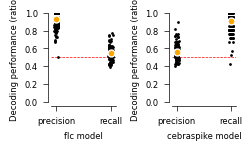

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(2.5, 1.5))
ax[0] = plotutils.plot(ax[0], flc_results["metric_data"])
ax[0].set_xlabel("flc model")
ax[1] = plotutils.plot(ax[1], cs_results["metric_data"])
ax[1].set_xlabel("cebraspike model")

plt.tight_layout()

# save
utils.savefig(
    "figures/1_sorting_quality/cebraspike/assets/fig5E_decoding_performance_evoked.svg"
)